In [2]:
import os, sys 
from pathlib import Path
from os.path import dirname, realpath
script_dir = Path(dirname(realpath('.')))
module_dir = str(script_dir)
sys.path.insert(0, module_dir + '/modules')
import numpy as np
import utility as ut
import matplotlib.pyplot as plt
import pandas as pd
import glob, json
from scipy import stats
import seaborn as sns
import oneshot as sm
import rfm, skipRFM, localRFM, localSkip, deepSkip, deepRFM, localDeepRFM, localDeepSkip, localDeepSkipN
# import parallel_euler as arch1
import torch, time
from torch import nn
import config
import count_params as cp
import wasserstein as w2
import matplotlib.pyplot as plt

clrs = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
L, p, q = 200, 1, 2
config_ids = ['config_1_s', 'config_1_s', 'config_1'][p:q]
train_sizes = [int(5e4), int(1e5), int(1e5)][p:q]
dynamical_systems = ['L63', 'L96', f'KS-{L}'][p:q]

data_folder = '../data'
N_hat = 10000

columns = ['dynamical_system', 'architecture', 'w2']


# for dynamical_system, config_id, train_size in zip(dynamical_systems, config_ids, train_sizes):
#     file_path = f'{data_folder}/{dynamical_system}-w2-flat.csv'
#     if os.path.exists(file_path):
#         os.remove(file_path)
#     print(f"Working on {dynamical_system} ...")
#     folder = f'{data_folder}/{dynamical_system}/{config_id}/attractor'
#     attractor = torch.tensor(np.load(f'{folder}/train.npy')).flatten().reshape(-1, 1)
#     random_index0 = torch.randperm(len(attractor))[:N_hat]
#     for architecture, setup, results in ut.get_best_models(dynamical_system, config_id, root=data_folder):
#         print(architecture)
#         architecture_ = architecture.split("_")[0]
#         reconstructed_attractor = torch.tensor(np.load(f'{folder}/{architecture_}/attractor.npy')).flatten().reshape(-1, 1)
#         random_index1 = torch.randperm(len(reconstructed_attractor))[:N_hat]
#         # print(reconstructed_attractor[random_index1].shape, attractor[random_index0].shape)
#         w = w2.sinkhorn_div(reconstructed_attractor[random_index1], attractor[random_index0])
#         results = [[dynamical_system, architecture, float(w)]]
#         pd.DataFrame(results, columns=columns).to_csv(file_path, mode='a', index=False, header=not os.path.exists(file_path))

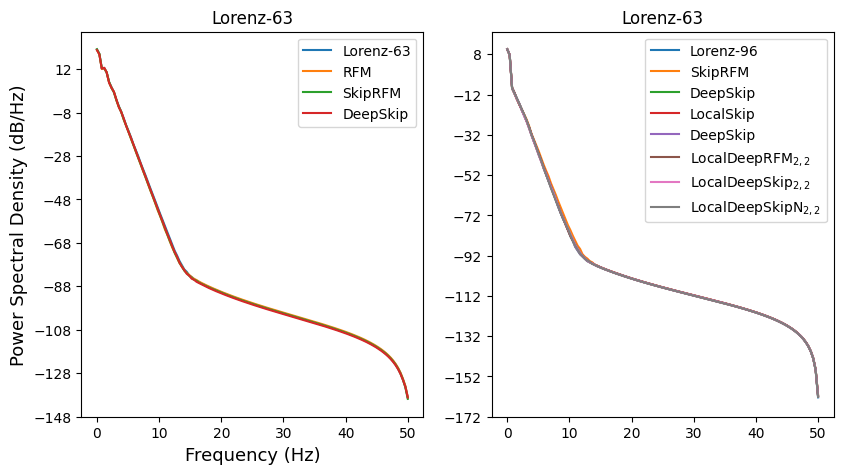

In [34]:
fig = plt.figure(figsize=(15, 5))
N = 100000

ax2 = fig.add_subplot(131)
root, config = '../data/L63', 'config_1_s'
folders = [f"{root}/{config}/attractor{a}" for a in ['', '/RFM', '/SkipRFM', '/DeepSkip']]
labels = ['Lorenz-63', 'RFM', 'SkipRFM', 'DeepSkip']
for i, data_folder in enumerate(folders):
    filename = "attractor" if i > 0 else "train"
    attractor = np.load(f"{data_folder}/{filename}.npy")[:, :N]
    ax2.psd(attractor.mean(axis=0), Fs=100, label=labels[i])

ax2.set_ylabel('Power Spectral Density (dB/Hz)', fontsize=13)
ax2.legend()
ax2.grid(False)
ax2.set_xlabel('Frequency (Hz)', fontsize=13)
ax2.set_title('Lorenz-63')


ax2 = fig.add_subplot(132)
root, config = '../data/L96', 'config_1_s'
folders = [f"{root}/{config}/attractor{a}" for a in ['', '/SkipRFM', '/DeepSkip', '/LocalSkip', '/DeepSkip', '/LocalDeepRFM',\
                                                     '/LocalDeepSkip', '/LocalDeepSkipN']]
labels = ['Lorenz-96', 'SkipRFM', 'DeepSkip', 'LocalSkip', 'DeepSkip', 'LocalDeepRFM'r'$_{2,2}$',\
                                          'LocalDeepSkip'r'$_{2,2}$', 'LocalDeepSkipN'r'$_{2,2}$']
for i, data_folder in enumerate(folders):
    filename = "attractor" if i > 0 else "train"
    attractor = np.load(f"{data_folder}/{filename}.npy")[:, :N]
    ax2.psd(attractor.mean(axis=0), Fs=100, label=labels[i])

ax2.set_ylabel('', fontsize=13)
ax2.legend()
ax2.grid(False)
ax2.set_xlabel('', fontsize=13)
ax2.set_title('Lorenz-96')

# ax2 = fig.add_subplot(133)
# root, config = '../data/KS-200', 'config_1'
# folders = [f"{root}/{config}/attractor{a}" for a in ['',  '/LocalDeepRFMN', '/LocalDeepSkipN']]
# labels = ['Kuramoto-Sivashinsky',  'LocalDeepRFMN'r'$_{8,1}$', 'LocalDeepSkipN'r'$_{8,1}$']
# for i, data_folder in enumerate(folders):
#     filename = "attractor" if i > 0  else "test"
#     attractor = np.load(f"{data_folder}/{filename}.npy")
#     if i == 0:
#         # attractor += 0.001 * np.random.normal(size=attractor.shape)
        
#         attractor = attractor.mean(axis=0)
#     ax2.psd(attractor[0], Fs=512, label=labels[i])

ax2.set_ylabel('', fontsize=13)
ax2.legend()
ax2.grid(False)
ax2.set_xlabel('', fontsize=13)
ax2.set_title('Lorenz-63')
# fig.subplots_adjust(wspace=0.3)
plt.savefig('../data/plots/final/psd.pdf', dpi=300, bbox_inches="tight")

**Training time**

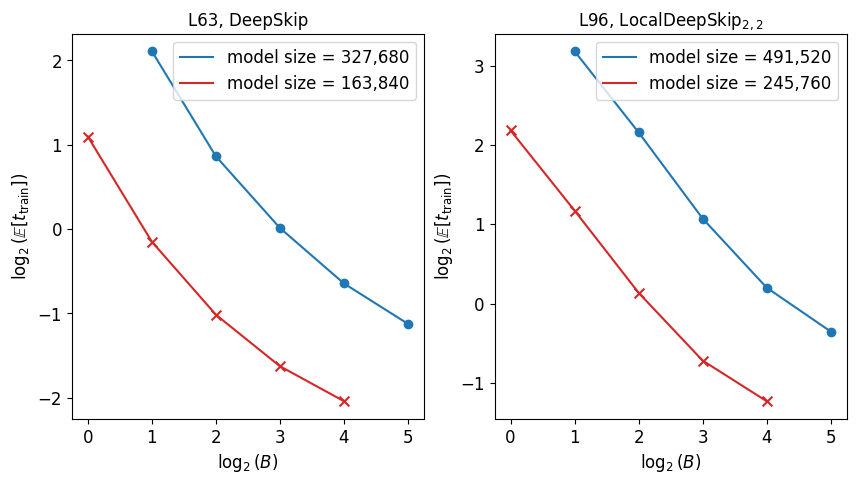

In [9]:
fig = plt.figure(figsize=(10, 5))
filename = '../data/plots/final/train-time.pdf'

ax = fig.add_subplot(121)
root = '../data/L63'
DrBs1 = [(16384, 2), (8192, 4), (4096, 8), (2048, 16), (1024, 32)]
DrBs2 = [(16384, 1), (8192, 2), (4096, 4), (2048, 8), (1024, 16)]
data_folders1 = [f'{root}/config_1_s/DeepSkip/D_r-{D_r}_B-{B}' for D_r, B in DrBs1]
data_folders2 = [f'{root}/config_1_s/DeepSkip/D_r-{D_r}_B-{B}' for D_r, B in DrBs2]



x, y = [], []
for i, folder in enumerate(data_folders1):
    data = pd.read_csv(folder + '/batch_data.csv')
    x.append(np.log2(DrBs1[i][1]))
    y.append(np.log2(data['train_time'].mean()))
    ax.scatter(x[-1], y[-1], c=clrs[0])
ax.plot(x, y, c=clrs[0], label='model size = 327,680')

x, y = [], []
for i, folder in enumerate(data_folders2):
    data = pd.read_csv(folder + '/batch_data.csv')
    x.append(np.log2(DrBs2[i][1]))
    y.append(np.log2(data['train_time'].mean()))
    ax.scatter(x[-1], y[-1], c=clrs[3], marker='x', s=50)
ax.plot(x, y, c=clrs[3], label='model size = 163,840')
ax.legend(fontsize=12)
ax.set_title('L63, DeepSkip')
ax.set_xlabel(r'$\log_2(B)$', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.set_ylabel(r'$\log_2(\mathbb{E}[t_{\rm train}])$', fontsize=12)


ax = fig.add_subplot(122)
root = '../data/L96'
DrBs1 = [(16384, 2), (8192, 4), (4096, 8), (2048, 16), (1024, 32)]
DrBs2 = [(16384, 1), (8192, 2), (4096, 4), (2048, 8), (1024, 16)]
data_folders1 = [f'{root}/config_1_s/LocalDeepSkip_2_2/D_r-{D_r}_B-{B}' for D_r, B in DrBs1]
data_folders2 = [f'{root}/config_1_s/LocalDeepSkip_2_2/D_r-{D_r}_B-{B}' for D_r, B in DrBs2]

filename = '../data/plots/final/train-time.pdf'

x, y = [], []
for i, folder in enumerate(data_folders1):
    data = pd.read_csv(folder + '/batch_data.csv')
    x.append(np.log2(DrBs1[i][1]))
    y.append(np.log2(data['train_time'].mean()))
    ax.scatter(x[-1], y[-1], c=clrs[0])
ax.plot(x, y, c=clrs[0], label='model size = 491,520')

x, y = [], []
for i, folder in enumerate(data_folders2):
    data = pd.read_csv(folder + '/batch_data.csv')
    x.append(np.log2(DrBs2[i][1]))
    y.append(np.log2(data['train_time'].mean()))
    ax.scatter(x[-1], y[-1], c=clrs[3], marker='x', s=50)
ax.plot(x, y, c=clrs[3], label='model size = 245,760')
ax.legend(fontsize=12)
ax.set_title('L96, LocalDeepSkip'r'$_{2,2}$')
ax.set_xlabel(r'$\log_2(B)$', fontsize=12)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=12)
ax.set_ylabel(r'$\log_2(\mathbb{E}[t_{\rm train}])$', fontsize=12)
plt.savefig(filename, bbox_inches="tight", dpi=300)